# Ejercicio 1: Gráfica computacionales
Define los nodos de una gráfica computacional para una red neuronal generando los nodos como
clases de python y utilizando únicamente numpy (no usar PyTorch, ni paqueterías especiales).
Genera los nodos para las funciones siguientes:

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

1. Linear: $\omega x + b$ donde $\omega$ y $b$ se inician de forma aleatoria. Debe tomar como argumentos el
tamaño de entrada del vector y el de salida.

In [2]:
class Linear():
    def __init__(self, input_size, output_size):
        self.grad = None
        #Inicializa w y b
        self.w = np.random.random((output_size, input_size))
        self.b = np.random.random(output_size)

    def __call__(self, x):
        # Convertir x a nodo
        # if not isinstance(x, Node):
        #     x = Node(x)

        # Realiza la función de wx+b
        self.value = np.dot(self.w, x) + self.b
        self.parent = x
        return self.value

    def __str__(self):
        return str(self.value)

2. Tanh: Función de activación de tangente hiperbólica definida como $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$.

In [3]:
class Tanh():
    def __init__(self):
        self.grad = None

    def __call__(self, x):
        # Convertir x a nodo
        # if not isinstance(x, Node):
        #     x = Node(x)
        # Realiza la función de tanh
        self.value = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        self.parent = x
        return self.value

    def __str__(self):
        return str(self.value)

3. Softmax: Función de activación definida como $\text{softmax} (x_i) = \frac{e_i^x}{\sum_j e^{x_j}}$ donde cada $x_i$ es una entrada del vector.

In [4]:
class Softmax():
    def __init__(self):
        self.grad = None

    def __call__(self, x):
        # Convertir x a nodo
        # if not isinstance(x, Node):
        #     x = Node(x)
            
        # Realiza la función de Softmax
        self.value = np.exp(x) / np.sum(np.exp(x))
        self.parent = x
        return self.value

    def __str__(self):
        return str(self.value)

4. CrossEntropy: Función que toma dos argumentos $x$ (vector) y $y$ (un entero o clase) y que se
estima de la forma $$R(x) = - \sum_j \delta_{j,y} \ln x_j$$ donde $\delta_{j,y} = 1$ si $j=y$ y $0$ en otro caso.

In [5]:
class CrossEntropy():
    def __init__(self):
        self.grad = None

    def __call__(self, x, y):
        # Convertir x a nodo
        # if not isinstance(x, Node):
        #     x = Node(x)
             
        # Se asegura que los valores están dentro del rango de logaritmo
        epsilon = 1e-15
        x_clip = np.clip(x, epsilon, None)

        # Ajusta el tipo de dato a array
        if isinstance(y, (list, np.ndarray)):
            # Asumimos que se refiere a clase como un conjunto de indices agrupados
            y = np.array(y)
        elif isinstance(y, int):
            y = np.array([y])

        # Realiza la función de R
        self.value = - np.sum( np.log(x_clip[y]) )
        self.parentA = x
        self.parentB = y
        return self

    def __str__(self):
        return str(self.value)

In [6]:
l1 = Linear(2,3)
act1 = Tanh()
l2 = Linear(3,2)
out = Softmax()
criterion = CrossEntropy()
x = np.array([1,2])
pred = out(l2(act1(l1(x))))
loss = criterion(pred, 1)
print(pred)
print(loss)

[0.4308166 0.5691834]
0.563552572783446


# Ejercicio 2: Cargadores de datos
Genera un cargador de datos a partir un dataset de tu preferencia. Este cargador de datos debe
contar con lo siguiente:

- El conjunto de datos $𝑥$ y las clases $𝑦$, ambas en formato torch (recuerda que 𝑥 debe ser flotante y $𝑦$ enteros largos).
- El tamaño del dataset size; es decir, el número total de datos que contiene.
- El tamaño de los tensores, sus dimensiones o número de features, feat_size. Si es necesario, realiza padding para que los datos sean del mismo tamaño.
- Una función de visualización plot que reduzca la dimensionalidad de los datos y los visualice en 2 dimensiones.

In [7]:
import torch.optim as optim
from sklearn import decomposition
from torch.utils.data import Dataset, DataLoader

In [60]:
class MyDataset(Dataset):
    def __init__(self,file_name):
        #Carga del csv
        dataframe = pd.read_csv(file_name, index_col=0)
        #Datos y clases
        self.features = list(dataframe.columns)
        x = dataframe.iloc[:,:-1].values
        y = dataframe.iloc[:,-1].values

        self.x = torch.tensor(x, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.long)

        #Tamaño de los datos
        self.size = self.x.size()

        # Número de features
        self.feat_size = x.shape[1]

    def __len__(self):
        #Regresa tamaño
        return len(self.y)

    def __getitem__(self,idx):
        #Regresa un dato
        return self.x[idx], self.y[idx]
    
    def plot(self, x_ind=None, y_ind=None, **kwargs):
        '''
        Graficar características del conjunto de datos
        x e y son los atributos del dataset a visualizar. Si x o y no se proporcionan,
        se calculará una reducción de dimensionalidad usando PCA. 

        Parameters:
        -----------
        x_ind,y_ind : int
            Índice de los atributos del dataset, para saber el número de atributos, usar el atributo "feat_size".
        **kwargs:
            Cualquier argumento de matplotlib.scatter    
        '''
        if isinstance(x_ind,type(None)) or isinstance(y_ind,type(None)):
            pca = decomposition.PCA(n_components=2)
            pca.fit(self.x)
            Z = pca.transform(self.x)
            plt.scatter(Z[:,0], Z[:,1], c=self.y, **kwargs)

        else:
            plt.scatter(self.x[:,x_ind], self.x[:,y_ind], c=self.y, **kwargs)
            plt.xlabel(self.features[x_ind])
            plt.ylabel(self.features[y_ind])

In [61]:
class BatchNormalization(torch.nn.Module):
    def __init__(self, num_features, eps=1e-6):
        super(BatchNormalization, self).__init__()
        self.eps = eps
        self.num_features = num_features
        self.a = torch.nn.Parameter(torch.ones(num_features))
        self.b = torch.nn.Parameter(torch.zeros(num_features))
          

    def forward(self, x):
        # Calcular la media y la varianza por lote
        mean = x.mean(dim=0)
        std = x.std(dim=0)

        # Normalizar los datos
        norm_x = self.a * (x - mean) / (std**2 + self.eps) + self.b

        return norm_x

- Usando los datos de `Heart Disease` de UCI:

In [62]:
data = MyDataset('heart_disease.csv')

torch.Size([270, 12])
12


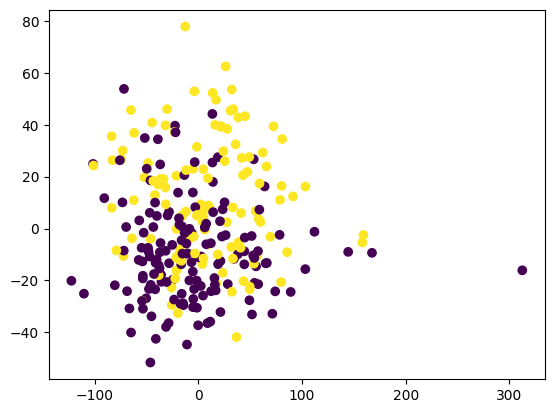

In [65]:
print(data.size)
print(data.feat_size)
data.plot()

In [67]:
# x tiene forma (batch_size, num_features)
loader = DataLoader(data, batch_size=70, shuffle=True)
norm = BatchNormalization(num_features=data.feat_size)

for x, y in loader:
    norm_x = norm(x)
    print(f"Media: {norm_x.mean():.4f}, Desviación estándar: {norm_x.std():.4f}")

Media: -0.0000, Desviación estándar: 1.4784
Media: 0.0000, Desviación estándar: 1.4251
Media: -0.0000, Desviación estándar: 1.4183
Media: -0.0000, Desviación estándar: 1.3573


- Usando los datos de `Dry Bean` de UCI:

In [68]:
data = MyDataset('dry_beans.csv')

torch.Size([13611, 16])
16


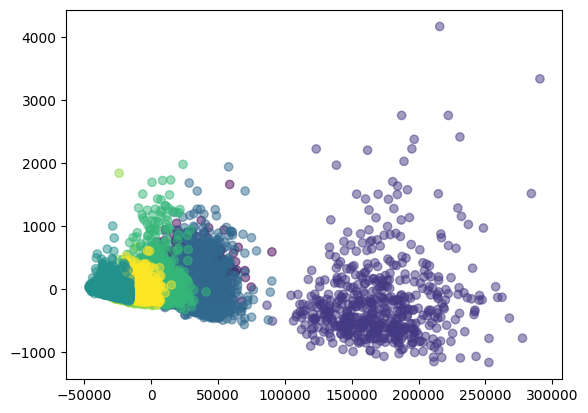

In [75]:
print(data.size)
print(data.feat_size)
data.plot(alpha=0.5)

In [70]:
# x tiene forma (batch_size, num_features)
loader = DataLoader(data, batch_size=1000, shuffle=True)
norm = BatchNormalization(num_features=data.feat_size)

for x, y in loader:
    norm_x = norm(x)
    print(f"Media: {norm_x.mean():.4f}, Desviación estándar: {norm_x.std():.4f}")

Media: -0.0001, Desviación estándar: 181.8107
Media: 0.0002, Desviación estándar: 183.2229
Media: -0.0001, Desviación estándar: 183.4763
Media: 0.0004, Desviación estándar: 186.7478
Media: -0.0000, Desviación estándar: 182.2235
Media: -0.0002, Desviación estándar: 179.2001
Media: 0.0000, Desviación estándar: 180.1940
Media: 0.0000, Desviación estándar: 182.0623
Media: -0.0001, Desviación estándar: 182.0596
Media: 0.0001, Desviación estándar: 181.7729
Media: 0.0001, Desviación estándar: 181.5910
Media: -0.0002, Desviación estándar: 180.0541
Media: 0.0003, Desviación estándar: 183.3819
Media: -0.0004, Desviación estándar: 183.1365
